In [1]:
import pandas as pd
import numpy as np
import polars as pl
import random
import joblib
import pathlib

from sklearn.metrics import roc_auc_score, classification_report

# Display options (optional)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

random.seed(42)
np.random.seed(42)

In [2]:
# Load path and get all the required files
def get_paths(base="fairness_artifacts"):
    base = pathlib.Path(base)
    return {
        "X_train": base / "X_train.parquet",
        "X_test": base / "X_test.parquet",
        "y_train": base / "y_train.parquet",
        "y_test": base / "y_test.parquet",
        "df_meta": base / "df_meta.parquet",
        "ids_test": base / "ids_test.parquet",
        "model": base / "final_lightgbm_model.pkl",
    }


def load_artifacts(base="fairness_artifacts"):
    paths = get_paths(base)

    X_train = pd.read_parquet(paths["X_train"])
    X_test = pd.read_parquet(paths["X_test"])
    y_train = pd.read_parquet(paths["y_train"])["hospitalized"]
    y_test = pd.read_parquet(paths["y_test"])["hospitalized"]
    df_meta = pd.read_parquet(paths["df_meta"])
    ids_test = pd.read_parquet(paths["ids_test"])["person_id"]
    model = joblib.load(paths["model"])

    return X_train, X_test, y_train, y_test, df_meta, ids_test, model

In [3]:
X_train, X_test, y_train, y_test, df_meta, ids_test, final_lgb = load_artifacts()

In [4]:
print("Shape:")
print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("y Train:", y_train.shape)
print("y Test:", y_test.shape)
print("ids_test:", ids_test.shape)
print("df_meta:", df_meta.shape)

Shape:
X Train: (15135, 65)
X Test: (3784, 65)
y Train: (15135,)
y Test: (3784,)
ids_test: (3784,)
df_meta: (18919, 10)


#### Core function for the fairness playground

For the fairness playground, I need a clean table that captures what the model actually did on the test set. Thus, I will now build a base evaluation table on the test set that includes person_id, the true label, the predicted probability, and the final 0/1 prediction. This is the core model-output layer I’ll use when joining with demographics and computing group-wise fairness metrics.

In [5]:
def make_base_eval_table(X_test, y_test, ids_test, model, threshold: float = 0.5):
    """
    Build a base evaluation table on the test set.

    Includes:
        - person_id: identifier for joining with demographics
        - y_true:    true hospitalization label
        - y_pred_proba: model's predicted probability for class 1
        - y_pred:   hard prediction using the given threshold
    """
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    df_eval = pd.DataFrame(
        {
            "person_id": ids_test.values,
            "y_true": y_test.values,
            "y_pred_proba": proba,
            "y_pred": y_pred,
        }
    )

    return df_eval

In [6]:
df_eval = make_base_eval_table(X_test, y_test, ids_test, final_lgb)
df_eval.head()

,person_id,y_true,y_pred_proba,y_pred
0,2795536102,0,0.000133,0
1,2796668104,0,0.000655,0
2,2815945102,0,0.000284,0
3,2813232102,0,0.001581,0
4,2810968102,0,0.000532,0


In [7]:
def merge_eval_and_meta(df_eval, df_meta):
    df_merged = df_eval.merge(df_meta, on="person_id", how="left")
    return df_merged


df_fair = merge_eval_and_meta(df_eval, df_meta)
print(df_fair.head())

    person_id  y_true  y_pred_proba  y_pred  age  sex  race_ethnicity  \
0  2795536102       0      0.000133       0   44    1               2   
1  2796668104       0      0.000655       0    4    1               1   
2  2815945102       0      0.000284       0   60    2               1   
3  2813232102       0      0.001581       0   59    1               2   
4  2810968102       0      0.000532       0   30    1               2   

   hispanic  poverty_category  insurance_coverage  family_income  \
0         2                 4                   1         142202   
1         1                 1                   2              0   
2         1                 4                   3          64010   
3         2                 5                   1         335489   
4         2                 4                   3          47840   

   self_rated_health  self_rated_mental_health  
0                2.0                       2.0  
1                4.0                       3.0  
2    

In [8]:
# merge model outputs with demographics
df_fair = merge_eval_and_meta(df_eval, df_meta)

df_fair.head()

,person_id,y_true,y_pred_proba,y_pred,age,sex,race_ethnicity,hispanic,poverty_category,insurance_coverage,family_income,self_rated_health,self_rated_mental_health
0,2795536102,0,0.000133,0,44,1,2,2,4,1,142202,2.0,2.0
1,2796668104,0,0.000655,0,4,1,1,1,1,2,0,4.0,3.0
2,2815945102,0,0.000284,0,60,2,1,1,4,3,64010,4.0,3.0
3,2813232102,0,0.001581,0,59,1,2,2,5,1,335489,2.0,2.0
4,2810968102,0,0.000532,0,30,1,2,2,4,3,47840,1.0,2.0


## Creating demographic buckets

For the fairness playground, I need clean group labels that I can slice the data by. Most demographic variables are continuous or very detailed (like age or income), so it helps to standardize them into simple categories. In this step, I create small helper columns—like age groups or poverty groups—that make it easy to compute fairness metrics and visualizations across different demographic slices.

In [9]:
def recode_demographics(df):
    # Sex: 1=Male, 2=Female
    sex_map = {
        1: "Male",
        2: "Female",
    }
    df["sex"] = df["sex"].map(sex_map)

    # Race/ethnicity (RACETHX style)
    race_map = {
        1: "Hispanic",
        2: "White",
        3: "Black",
        4: "Asian",
        5: "Other or Multiple",
    }
    df["race_ethnicity"] = df["race_ethnicity"].map(race_map)

    # Hispanic flag: 1=Hispanic, 2=Not Hispanic
    hisp_map = {
        1: "Hispanic",
        2: "Not Hispanic",
    }
    df["hispanic"] = df["hispanic"].map(hisp_map)

    # Poverty category (POVCAT23)
    pov_map = {
        1: "Poor or negative",
        2: "low income",
        3: "Middle income",
        4: "High income",
        5: "Unclassifiable",
    }
    df["poverty_category"] = df["poverty_category"].map(pov_map)

    # Insurance coverage (INSCOV23)
    ins_map = {
        1: "Any private",
        2: "Public only",
        3: "Uninsured",
    }
    df["insurance_coverage"] = df["insurance_coverage"].map(ins_map)

    # Self-rated health: 1–5 (Excellent→Poor)
    health_map = {
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
    }
    df["self_rated_health"] = (
        df["self_rated_health"].round().astype("Int64").map(health_map)
    )

    # Self-rated mental health: 1–5 (Excellent→Poor)
    df["self_rated_mental_health"] = (
        df["self_rated_mental_health"].round().astype("Int64").map(health_map)
    )

    return df

In [10]:
df_clean = recode_demographics(df_fair)
print(df_fair.head())

    person_id  y_true  y_pred_proba  y_pred  age     sex race_ethnicity  \
0  2795536102       0      0.000133       0   44    Male          White   
1  2796668104       0      0.000655       0    4    Male       Hispanic   
2  2815945102       0      0.000284       0   60  Female       Hispanic   
3  2813232102       0      0.001581       0   59    Male          White   
4  2810968102       0      0.000532       0   30    Male          White   

       hispanic  poverty_category insurance_coverage  family_income  \
0  Not Hispanic       High income        Any private         142202   
1      Hispanic  Poor or negative        Public only              0   
2      Hispanic       High income          Uninsured          64010   
3  Not Hispanic    Unclassifiable        Any private         335489   
4  Not Hispanic       High income          Uninsured          47840   

  self_rated_health self_rated_mental_health  
0         Very good                Very good  
1              Fair         

## Step 5: Build group-level fairness summary tables

Now that the fairness dataset is ready, I can start evaluating how the model behaves across different demographic groups. Here I build a small helper function that computes simple group-level metrics like accuracy, precision, recall, average predicted probability, and the overall positive prediction rate. These summaries help reveal whether the model treats different groups similarly or not, which is the core purpose of the fairness playground.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


def group_metrics(df, group_col):
    """
    Compute basic fairness metrics by a demographic group.
    """
    results = []

    for group, g in df.groupby(group_col):
        acc = accuracy_score(g["y_true"], g["y_pred"])
        prec = precision_score(g["y_true"], g["y_pred"], zero_division=0)
        rec = recall_score(g["y_true"], g["y_pred"], zero_division=0)

        avg_proba = g["y_pred_proba"].mean()
        positive_rate = g["y_pred"].mean()  # % of predictions that are 1

        results.append(
            {
                group_col: group,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "avg_pred_probability": avg_proba,
                "positive_prediction_rate": positive_rate,
                "count": len(g),
            }
        )

    return pd.DataFrame(results)

In [12]:
race_summary = group_metrics(df_fair, "race_ethnicity")
print(race_summary)

      race_ethnicity  accuracy  precision    recall  avg_pred_probability  \
0              Asian  0.954545   0.500000  0.700000              0.068714   
1              Black  0.924949   0.582090  0.812500              0.141904   
2           Hispanic  0.937805   0.388060  0.722222              0.087824   
3  Other or Multiple  0.961538   0.733333  0.846154              0.112972   
4              White  0.911695   0.476364  0.761628              0.143236   

   positive_prediction_rate  count  
0                  0.063636    220  
1                  0.135903    493  
2                  0.081707    820  
3                  0.096154    156  
4                  0.131265   2095  


When I look at the model’s performance across racial and ethnic groups, it’s clear that the model is not behaving uniformly. Asian individuals have the highest overall accuracy and the lowest rate of positive predictions, suggesting the model is more conservative with this group. Black and White individuals receive higher predicted probabilities and higher positive prediction rates, meaning the model tends to assign higher risk scores to these groups. Hispanic individuals show lower precision, which means the model produces more false alarms for this group compared to others. The “Other or Multiple” group actually shows the strongest combination of precision and recall. All of this variation is useful to surface because it shows that even though the model is generally strong, different groups experience the model differently—something the fairness playground is built to make transparent.

In [13]:
sex_summary = group_metrics(df_fair, "sex")
print(sex_summary)

      sex  accuracy  precision    recall  avg_pred_probability  \
0  Female  0.909790   0.467742  0.725000              0.137617   
1    Male  0.938352   0.515789  0.823529              0.112551   

   positive_prediction_rate  count  
0                  0.127114   1951  
1                  0.103655   1833  


The sex-based summary shows another pattern worth noting. The model predicts hospitalization more frequently for women, assigning them higher average predicted probabilities and producing more positive predictions overall. However, these predictions are less precise compared to those for men, meaning the model generates more false positives for women. In contrast, the model is more conservative with men but produces higher accuracy, precision, and recall when it does predict hospitalization. 

This pattern where women have more false positives and men have more false negatives is consistent with what has been found in real healthcare systems. Women tend to have more clinical encounters, report symptoms earlier, and accumulate more coded history in administrative data, which makes risk models more likely to flag them as high-risk even when the actual event rate is lower. Men, on the other hand, often seek care later and generate fewer data points, which results in lower predicted risk but a higher chance of missed severe cases. These behavioral and utilization differences show up in many risk-prediction studies and can create systematic disparities even when the model itself is not intentionally biased. This is exactly why fairness and explainability tools are useful — they help uncover these kinds of patterns before a model is deployed.

References:
- https://www.nejm.org/doi/full/10.1056/NEJMp1606181
- https://pubmed.ncbi.nlm.nih.gov/27036116/

## Step 6: Computing fairness Disparity Metrics

Now that I have group-level results, I want to see how each group compares to the others. In this step, I calculate simple fairness disparity metrics — things like differences in positive prediction rates, recall gaps, false negative rate gaps, and false positive rate gaps. These values show whether the model is systematically more sensitive or more lenient for some groups compared to a reference group. This is important for explainability because it makes any unequal model behavior visible and easy to understand.

In [14]:
def disparity_table(df, group_col, reference_group=None):
    """
    Compute basic fairness disparity metrics relative to a reference group.

    Metrics:
        - Positive prediction rate gap
        - Recall gap (Equal Opportunity)
        - Precision gap
        - False negative rate gap
        - False positive rate gap
    """
    # If no reference group specified, use the largest group
    if reference_group is None:
        reference_group = df[group_col].value_counts().idxmax()

    # Prepare output
    rows = []

    # Pre-calc for reference group
    ref = df[df[group_col] == reference_group]
    ref_pos_rate = ref["y_pred"].mean()
    ref_recall = (ref["y_pred"].eq(1) & ref["y_true"].eq(1)).sum() / max(
        ref["y_true"].sum(), 1
    )
    ref_precision = (ref["y_pred"].eq(1) & ref["y_true"].eq(1)).sum() / max(
        ref["y_pred"].sum(), 1
    )

    ref_fnr = 1 - ref_recall
    ref_fpr = ((ref["y_pred"].eq(1) & ref["y_true"].eq(0)).sum()) / max(
        (ref["y_true"] == 0).sum(), 1
    )

    for group in df[group_col].unique():
        g = df[df[group_col] == group]

        # Metrics for the group
        pos_rate = g["y_pred"].mean()
        recall = (g["y_pred"].eq(1) & g["y_true"].eq(1)).sum() / max(
            g["y_true"].sum(), 1
        )
        precision = (g["y_pred"].eq(1) & g["y_true"].eq(1)).sum() / max(
            g["y_pred"].sum(), 1
        )

        fnr = 1 - recall
        fpr = ((g["y_pred"].eq(1) & g["y_true"].eq(0)).sum()) / max(
            (g["y_true"] == 0).sum(), 1
        )

        rows.append(
            {
                group_col: group,
                "positive_rate": pos_rate,
                "positive_rate_gap_vs_ref": pos_rate - ref_pos_rate,
                "recall": recall,
                "recall_gap_vs_ref": recall - ref_recall,
                "precision": precision,
                "precision_gap_vs_ref": precision - ref_precision,
                "false_negative_rate": fnr,
                "fnr_gap_vs_ref": fnr - ref_fnr,
                "false_positive_rate": fpr,
                "fpr_gap_vs_ref": fpr - ref_fpr,
                "count": len(g),
            }
        )

    return pd.DataFrame(rows), reference_group

In [15]:
race_disp, ref_race = disparity_table(df_fair, "race_ethnicity")
print(race_disp)

      race_ethnicity  positive_rate  positive_rate_gap_vs_ref    recall  \
0              White       0.131265                  0.000000  0.761628   
1           Hispanic       0.081707                 -0.049558  0.722222   
2              Black       0.135903                  0.004638  0.812500   
3  Other or Multiple       0.096154                 -0.035111  0.846154   
4              Asian       0.063636                 -0.067629  0.700000   

   recall_gap_vs_ref  precision  precision_gap_vs_ref  false_negative_rate  \
0           0.000000   0.476364              0.000000             0.238372   
1          -0.039406   0.388060             -0.088304             0.277778   
2           0.050872   0.582090              0.105726             0.187500   
3           0.084526   0.733333              0.256970             0.153846   
4          -0.061628   0.500000              0.023636             0.300000   

   fnr_gap_vs_ref  false_positive_rate  fpr_gap_vs_ref  count  
0        0.00000

When I compare each race/ethnicity group to the reference group (White), the model clearly behaves differently across groups. Hispanic and Asian individuals have lower positive prediction rates and slightly lower recall, meaning the model is more conservative and misses more true cases in these groups. In contrast, Black individuals have a slightly higher positive prediction rate and higher recall, meaning the model is more sensitive for this group and detects more true cases. The “Other or Multiple” group shows the best recall and the lowest false negative rate, which indicates the model performs unusually well there. These gaps don’t necessarily mean the model is biased, but they do show that the model is not uniform across groups.

In [16]:
sex_disp, ref_sex = disparity_table(df_fair, "sex")
print(sex_disp)

      sex  positive_rate  positive_rate_gap_vs_ref    recall  \
0    Male       0.103655                 -0.023459  0.823529   
1  Female       0.127114                  0.000000  0.725000   

   recall_gap_vs_ref  precision  precision_gap_vs_ref  false_negative_rate  \
0           0.098529   0.515789              0.048048             0.176471   
1           0.000000   0.467742              0.000000             0.275000   

   fnr_gap_vs_ref  false_positive_rate  fpr_gap_vs_ref  count  
0       -0.098529             0.053676       -0.020026   1833  
1        0.000000             0.073702        0.000000   1951  


The sex disparity table shows a clear difference: women serve as the reference group, and men have noticeably lower positive prediction rates but higher recall. This means the model predicts hospitalization less often for men, but when it does, it detects more true cases. Women, on the other hand, receive more positive predictions overall and have higher false positive and false negative rates compared to men. This pattern mirrors what often happens in real healthcare models, where women’s higher utilization leads to more “risk signals” in the data.

## Build Fairness Visualization Functions

Now that I have group-level metrics and disparity tables, I want to make the results more intuitive by adding visualizations. Charts make it easier to see where the model performs differently across groups and where the largest gaps appear. Here I create small plotting functions for group metrics, disparity gaps, and predicted-probability distributions. These visuals will later be used directly in the fairness playground to help users explore how the model behaves across race, sex, income, and other demographic slices.

### 7.1 — Metric Bar Chart

In [17]:
import matplotlib.pyplot as plt


def plot_group_metric(df, group_col, metric, title=None):
    """
    Simple bar chart of a fairness metric by group.
    df = group metrics table from Step 5
    metric = "accuracy", "recall", "precision", etc.
    """
    plt.figure(figsize=(8, 4))
    plt.bar(df[group_col], df[metric])
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.title(title if title else f"{metric} by {group_col}")
    plt.show()

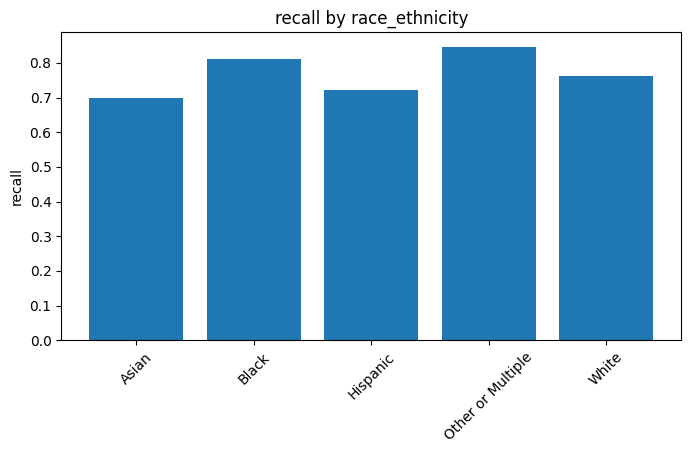

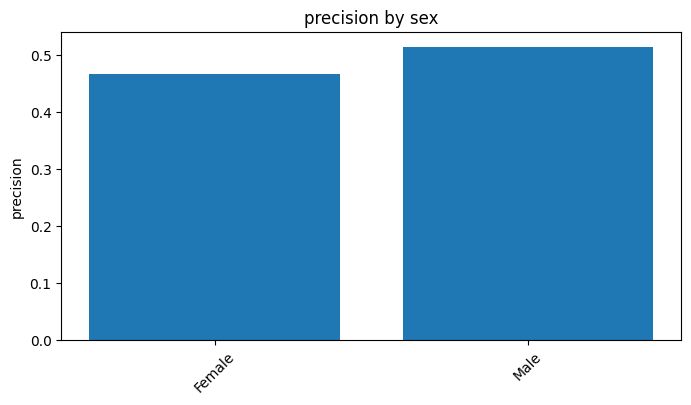

In [18]:
plot_group_metric(race_summary, "race_ethnicity", "recall")
plot_group_metric(sex_summary, "sex", "precision")

### 7.2 — Disparity Gap Bar Chart

In [19]:
def plot_disparity(df, group_col, gap_col, title=None):
    """
    Plot disparity gaps (vs reference group).
    gap_col examples: "recall_gap_vs_ref", "positive_rate_gap_vs_ref"
    """
    plt.figure(figsize=(8, 4))
    plt.bar(df[group_col], df[gap_col])
    plt.axhline(0, color="black", linewidth=1)
    plt.ylabel("Gap vs reference")
    plt.xticks(rotation=45)
    plt.title(title if title else f"{gap_col} by {group_col}")
    plt.show()

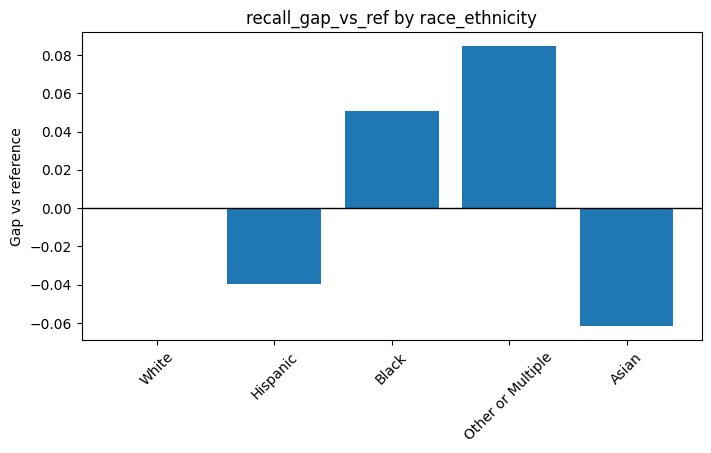

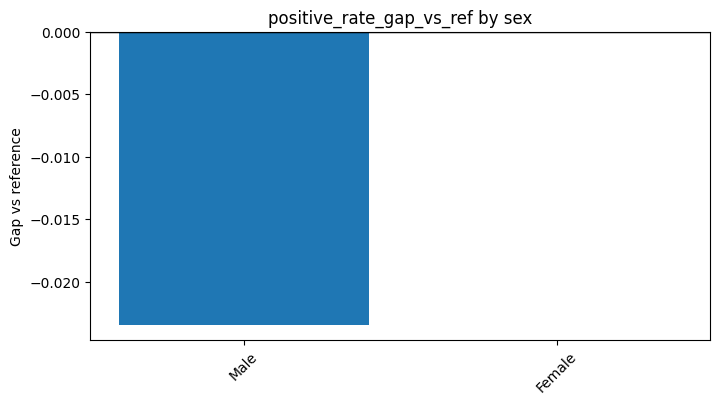

In [20]:
plot_disparity(race_disp, "race_ethnicity", "recall_gap_vs_ref")
plot_disparity(sex_disp, "sex", "positive_rate_gap_vs_ref")

### 7.3 — Predicted Probability Distributions (per group)

In [21]:
def plot_proba_distributions(df, group_col):
    groups = df[group_col].unique()

    plt.figure(figsize=(10, 6))

    for g in groups:
        subset = df[df[group_col] == g]["y_pred_proba"]
        plt.hist(subset, bins=30, alpha=0.4, label=g, density=True)

    plt.xlabel("Predicted probability")
    plt.ylabel("Density")
    plt.title(f"Predicted probability distributions by {group_col}")
    plt.legend()
    plt.show()